# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import log_loss, classification_report
#from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [73]:
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

In [74]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [75]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables que pueden ser útiles para el modelo

In [76]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,5,1,0,0,draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,5,1,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,5,1,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,5,1,0,4,draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,5,1,3,3,win


In [77]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         48532 non-null  datetime64[ns]
 1   home_team    48532 non-null  object        
 2   away_team    48532 non-null  object        
 3   home_score   48532 non-null  int64         
 4   away_score   48532 non-null  int64         
 5   tournament   48532 non-null  object        
 6   city         48532 non-null  object        
 7   country      48532 non-null  object        
 8   neutral      48532 non-null  bool          
 9   year         48532 non-null  int32         
 10  month        48532 non-null  int32         
 11  dayofweek    48532 non-null  int32         
 12  is_weekend   48532 non-null  int64         
 13  goal_diff    48532 non-null  int64         
 14  total_score  48532 non-null  int64         
 15  result       48532 non-null  object        
dtypes: b

In [78]:
results.describe()

,date,home_score,away_score,year,month,dayofweek,is_weekend,goal_diff,total_score
count,48532,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000
mean,1993-10-17 04:11:45.579823488,1.758180,1.181550,1993.265557,6.883664,3.457018,0.395945,1.716208,2.939730
min,1872-11-30 00:00:00,0.000000,0.000000,1872.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1980-02-27 00:00:00,1.000000,0.000000,1980.000000,4.000000,2.000000,0.000000,1.000000,1.000000
50%,2000-03-15 00:00:00,1.000000,1.000000,2000.000000,7.000000,3.000000,0.000000,1.000000,3.000000
75%,2012-11-07 06:00:00,2.000000,2.000000,2012.000000,10.000000,5.000000,1.000000,2.000000,4.000000
max,2025-09-09 00:00:00,31.000000,21.000000,2025.000000,12.000000,6.000000,1.000000,31.000000,31.000000
std,NaN,1.773101,1.400946,25.301688,3.228533,1.981937,0.489058,1.791796,2.095142


Visualizaciones de variables numéricas

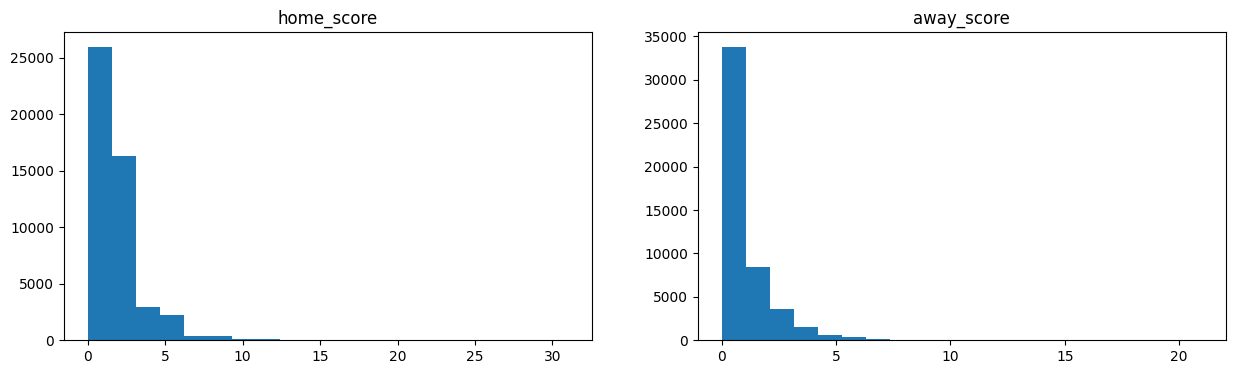

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

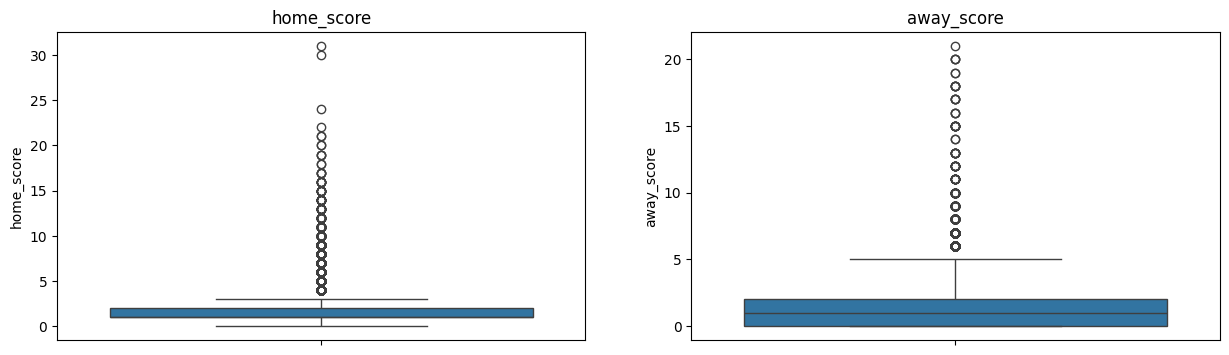

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

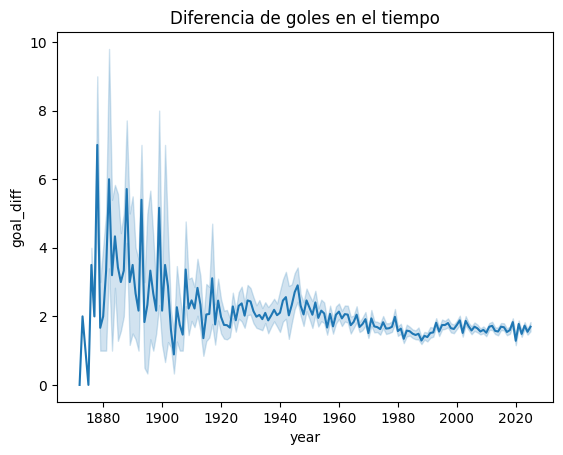

In [81]:
sns.lineplot(data=results, x="year", y="goal_diff")
plt.title("Diferencia de goles en el tiempo")
plt.show()

Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

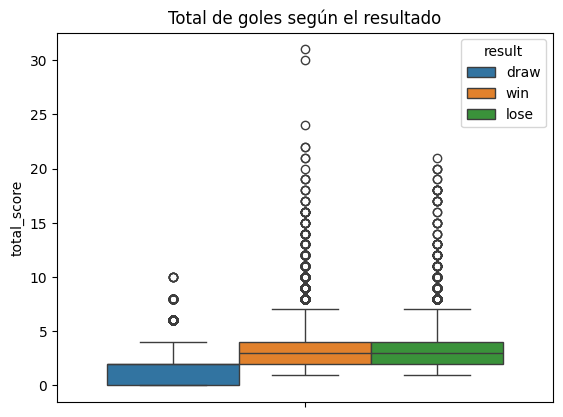

In [82]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

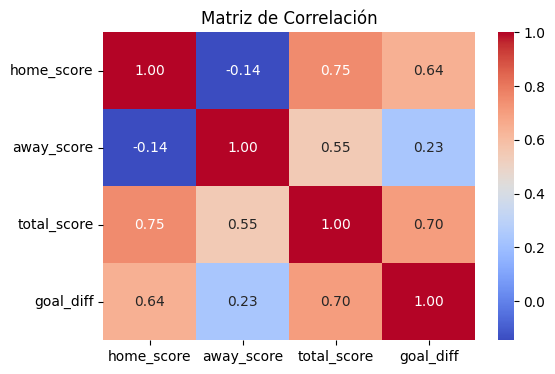

In [83]:
corr = results[["home_score", "away_score", "total_score", "goal_diff"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Visualización de variables categoricas

In [84]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')

In [85]:
results.describe(include='category')

,home_team,away_team,tournament,city,country,result
count,48532,48532,48532,48532,48532,48532
unique,325,318,188,2115,268,3
top,Brazil,Uruguay,Friendly,Kuala Lumpur,United States,win
freq,608,578,18116,736,1458,23797


Veamos la distribución del target

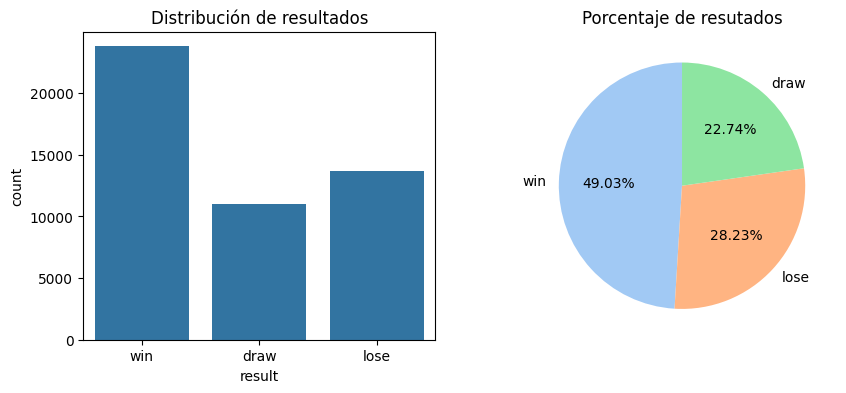

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

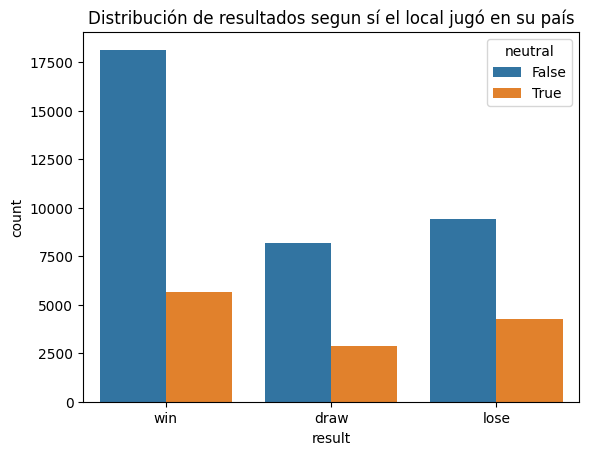

In [87]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()

Como la cardinalidad de las variables categoricas es muy alta, vamos a graficar aquellos valores que más se destacan:

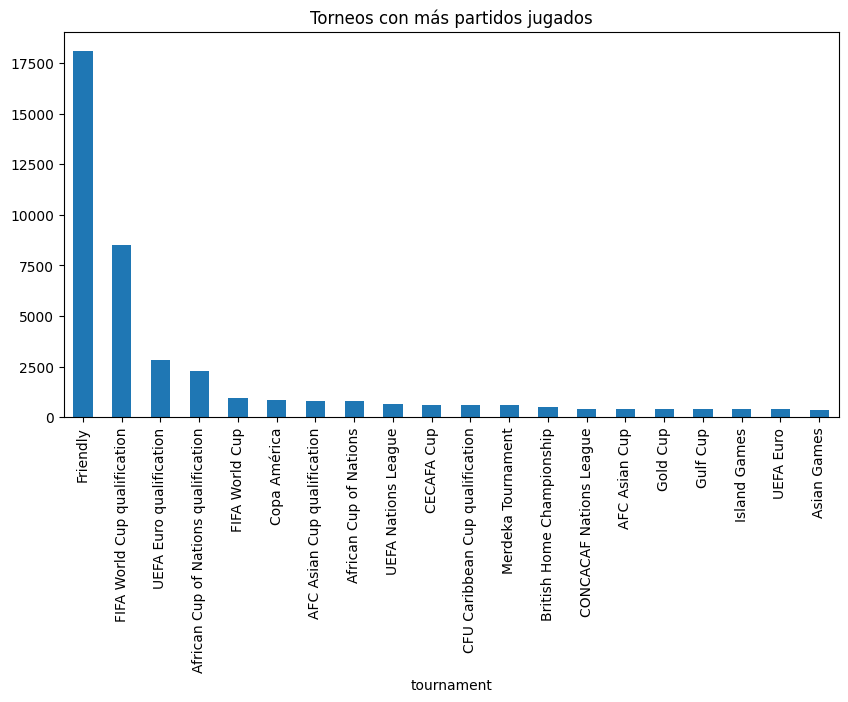

In [88]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(20).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

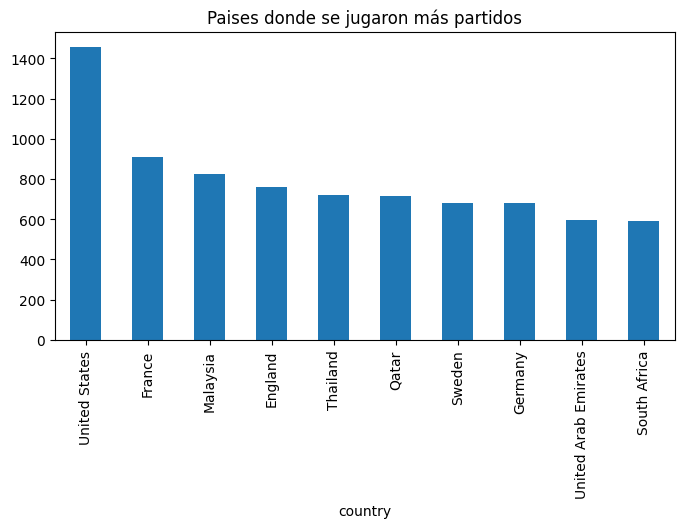

In [89]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

De los torneos, se destaca el tipo "amistoso" pero también aprecen torneos pocos conocidos a la par de otros mas conocidos a nivel mundial.

Con los paises sucede algo similar, paises como Malasia o Tailandia tienen una cantidad de partidos importantes.

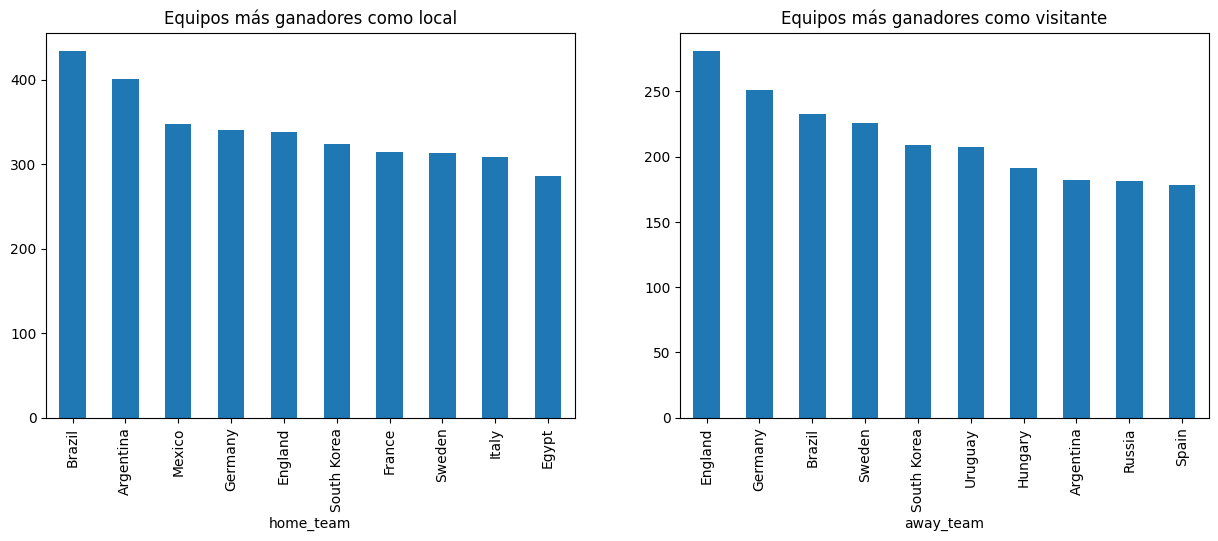

In [90]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

 Como el objetivo es predecir el resultado del partido, no podemos usar los datos del registro, ya que estos son posteriores al partido. Por lo tanto, se crean nuevas variables que representen el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*. Por ejemplo:
- Tasa de partidos ganados en los últimos N partidos
- Promedio de goles a favor y en contra en los últimos N partidos

In [91]:
window_size = 10  # cantidad de partidos a considerar

# Calcular winrate del equipo local con los registros previos ordenados por fecha
results["home_n_winrate"] = (
    results.groupby("home_team")["result"]
      .apply(lambda x: x.shift().eq("win").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Calcular winrate del equipo visitante con los registros previos ordenados por fecha
results['away_n_winrate'] = (
    results.groupby('away_team')['result']
      .apply(lambda x: x.shift().eq("lose").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Calcular loserate del equipo local
results["home_n_loserate"] = (
  results.sort_values("date")
    .groupby("home_team")["result"]
    .apply(lambda x: x.shift().eq("lose").rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

# Calcular loserate del equipo visitante
results["away_n_loserate"] = (
  results.sort_values("date")
    .groupby("away_team")["result"]
    .apply(lambda x: x.shift().eq("win").rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

# Calcular drawrate del equipo local
results["home_n_drawrate"] = (
  results.sort_values("date")
    .groupby("home_team")["result"]
    .apply(lambda x: x.shift().eq("draw").rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

results["away_n_drawrate"] = (
  results.sort_values("date")
    .groupby("away_team")["result"]
    .apply(lambda x: x.shift().eq("draw").rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

# Promedio de goles a favor
results['home_n_avg_gf'] = (
  results.groupby('home_team')['home_score']
    .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)    
)

results['away_n_avg_gf'] = (
  results.groupby('away_team')['away_score']
    .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)    
)

# Promedio de goles en contra
results['home_n_avg_ga'] = (
  results.groupby('home_team')['away_score']
    .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

results['away_n_avg_ga'] = (
  results.groupby('away_team')['home_score']
    .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

/var/folders/ff/89s4xv1x5210pv23kt90w28c0000gn/T/ipykernel_28232/679440281.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby("home_team")["result"]
/var/folders/ff/89s4xv1x5210pv23kt90w28c0000gn/T/ipykernel_28232/679440281.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('away_team')['result']
/var/folders/ff/89s4xv1x5210pv23kt90w28c0000gn/T/ipykernel_28232/679440281.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

Se filtran los partidos de modo que queden aquellos que se jugaron desde de 1920, ya que los anteriores pueden introducir ruido en el modelo. Vimos partidos con muchos goles antes de 1920, el fútbol era diferente entonces y había más diferencia entre los equipos.

In [92]:
results_filtered = results[results["date"].dt.year >= 1920].reset_index(drop=True)

results_filtered, test_df = train_test_split(results_filtered, test_size=0.2, random_state=42)

# También probamos con un split basado en fecha pero los resultados no fueron buenos
# test_df = results[results["date"] >= "2015-01-01"]
# results_filtered = results[results["date"] < "2015-01-01"]

print("Train shape:", results_filtered.shape)
print("Test shape:", test_df.shape)

Train shape: (38350, 26)
Test shape: (9588, 26)


In [93]:
# Null checks
print(results_filtered.isna().sum()[results_filtered.isna().sum() > 0])
print(test_df.isna().sum()[test_df.isna().sum() > 0])

home_n_avg_gf    233
away_n_avg_gf    232
home_n_avg_ga    233
away_n_avg_ga    232
dtype: int64
home_n_avg_gf    57
away_n_avg_gf    51
home_n_avg_ga    57
away_n_avg_ga    51
dtype: int64


En base al procesamiento realizado, aparecen valores nulos en el promedio de goles a favor y en contra. Se decide imputar estos valores con 1.

In [94]:
features_nulls = [
    'home_n_avg_gf',
    'home_n_avg_ga',
    'away_n_avg_gf',
    'away_n_avg_ga',
]

results_filtered[features_nulls] = results_filtered[features_nulls].fillna(1.0)
test_df[features_nulls] = test_df[features_nulls].fillna(1.0)

In [95]:
# Creamos deltas entre las métricas de ambos equipos, quizas son más predictivas

results_filtered["delta_winrate"] = results_filtered["home_n_winrate"] - results_filtered["away_n_winrate"]
results_filtered["delta_loserate"] = results_filtered["home_n_loserate"] - results_filtered["away_n_loserate"]
results_filtered["delta_drawrate"] = results_filtered["home_n_drawrate"] - results_filtered["away_n_drawrate"]
results_filtered["delta_avg_gf"] = results_filtered["home_n_avg_gf"] - results_filtered["away_n_avg_gf"]
results_filtered["delta_avg_ga"] = results_filtered["home_n_avg_ga"] - results_filtered["away_n_avg_ga"]

test_df["delta_winrate"] = test_df["home_n_winrate"] - test_df["away_n_winrate"]
test_df["delta_loserate"] = test_df["home_n_loserate"] - test_df["away_n_loserate"]
test_df["delta_drawrate"] = test_df["home_n_drawrate"] - test_df["away_n_drawrate"]
test_df["delta_avg_gf"] = test_df["home_n_avg_gf"] - test_df["away_n_avg_gf"]
test_df["delta_avg_ga"] = test_df["home_n_avg_ga"] - test_df["away_n_avg_ga"]

# results_filtered["neutral"] = results_filtered["neutral"].astype(int)
# test_df["neutral"] = test_df["neutral"].astype(int)

# recordemos las columnas actuales para selección de features
results_filtered.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'year', 'month',
       'dayofweek', 'is_weekend', 'goal_diff', 'total_score', 'result',
       'home_n_winrate', 'away_n_winrate', 'home_n_loserate',
       'away_n_loserate', 'home_n_drawrate', 'away_n_drawrate',
       'home_n_avg_gf', 'away_n_avg_gf', 'home_n_avg_ga', 'away_n_avg_ga',
       'delta_winrate', 'delta_loserate', 'delta_drawrate', 'delta_avg_gf',
       'delta_avg_ga'],
      dtype='object')

Codificamos las variables categoricas:

Pero antes veamos el peso de cada una en las predicciones, se hace un test anova mediante SelectFpra y se revisan los pesos.

- home_team, observamos que no aporta significativamente
- away_team, observamos que no aporta significativamente
- tournament, observamos que no aporta significativamente
- city, se podría evitar! genera dependencia lineal entre home_team, city, country  
- country, se podría evitar! genera dependencia lineal entre home_team, city, country  
- neutral, observamos que no aporta significativamente.
- month, se codifica con Cyclic Encoding y observamos que es la que menos aporta


Codificación: 

Ahora las que seleccionamos según el análisis son las que más aportan, y como son númericas se escalan para que queden en la misma escala, con StandardScaler:
- "delta_winrate"
- "delta_loserate"
- "delta_avg_gf",
- "delta_avg_ga"

El target:
- result se codifica con LabelEncoder por ser la variable a predecir

In [96]:
# --- Definir variables ---
features_categoricas_target = ["tournament"] #["away_team", "tournament" ] #"country", "home_team",  "city", "year", "home_team", 
features_categoricas_one_hot = [] #["neutral"] #, "is_weekend"]

# Habíamos probado con estas features sin buenos resultados
# El mes es ciclico y lo debemos encodear como tal
#results_filtered["month_sin"] = np.sin(2 * np.pi * results_filtered["month"] / 12)
#results_filtered["month_cos"] = np.cos(2 * np.pi * results_filtered["month"] / 12)

features_numericas = ["delta_winrate", "delta_loserate", #"delta_drawrate",
                     "delta_avg_gf", "delta_avg_ga"]
                    #  ["home_n_winrate", "home_n_loserate", "home_n_drawrate", 
                    #   "away_n_winrate", "away_n_loserate", "away_n_drawrate",
                    #   "home_n_avg_gf", "home_n_avg_ga",
                    #   "away_n_avg_gf", "away_n_avg_ga"
                    #   ] #"month_sin", "month_cos", "home_score", "away_score", 

In [97]:

result_encoder = LabelEncoder()
results_filtered["result_enc"] = result_encoder.fit_transform(results_filtered["result"])

test_df["result_enc"] = result_encoder.transform(test_df["result"])
print("Clases del resultado: ", result_encoder.classes_)

# neutral no se usó al final
#results_filtered["neutral"] = results_filtered["neutral"].astype(str)
#test_df["neutral"] = test_df["neutral"].astype(str)

# Separar X / y ---
X = results_filtered[features_numericas + features_categoricas_one_hot + features_categoricas_target]
y = results_filtered["result_enc"]

# Preprocesamiento: escalado + one-hot y target encoding 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_numericas),
        #("cat_o", OneHotEncoder(handle_unknown="ignore"), features_categoricas_one_hot),
        #("cat_t", TargetEncoder(handle_unknown="ignore"), features_categoricas_target)
    ]
)

# Pipeline general ---
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# --- Aplicar transformaciones ---
X_processed = pipeline.fit_transform(X, y)

print("Shape original:", X.shape)
print("Shape transformada:", X_processed.shape)


Clases del resultado:  ['draw' 'lose' 'win']
Shape original: (38350, 5)
Shape transformada: (38350, 4)


In [98]:
# Esto lo usamos para visualizar un equipo en particular

#X[((X['home_team'].isin(['Colombia'])))] #| (X['away_team'].isin(['Colombia']))) & (X['year'] == 2025)]

#y[((y['home_team'].isin(['Colombia'])) | (y['away_team'].isin(['Colombia']))) & (y['year'] == 2025)]

In [99]:
from sklearn.feature_selection import SelectFpr, f_classif 
selector_anova = SelectFpr(score_func=f_classif, alpha=0.05)

selector_anova.fit(X_processed, y)

print("Número de variables seleccionadas:", selector_anova.get_support().sum())

Número de variables seleccionadas: 4


In [100]:
# Esto significa que las 4 columnas finales tienen una relación estadísticamente significativa (p < 0.05) con tu variable objetivo y.

# Ahora miremos los pesos
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
scores = pd.DataFrame({
    "feature": feature_names,
    "f_score": selector_anova.scores_,
    "p_value": selector_anova.pvalues_
}).sort_values("f_score", ascending=False)

print(scores)

               feature      f_score  p_value
1  num__delta_loserate  2037.415902      0.0
0   num__delta_winrate  1952.753200      0.0
3    num__delta_avg_ga  1850.556313      0.0
2    num__delta_avg_gf  1262.856888      0.0


Quedan en total 4 variables significativas. En pruebas anteriores encontramos que otras son linealmente dependientes y se excluyeron y otras no representan relación estadistica con la variable objetivo.

<Axes: >

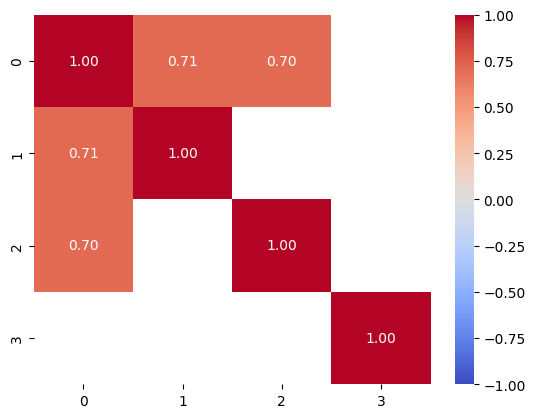

In [101]:
X_df = pd.DataFrame(X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed)
corr = np.abs(pd.DataFrame(X_df).corr())

mask_for_heatmap = corr < 0.70

sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm",  
    center=0, 
    vmin=-1, 
    vmax=1,
    mask=mask_for_heatmap)

Hemos reducido la dimensionalidad hasta llegar a las 4 variables más significativas

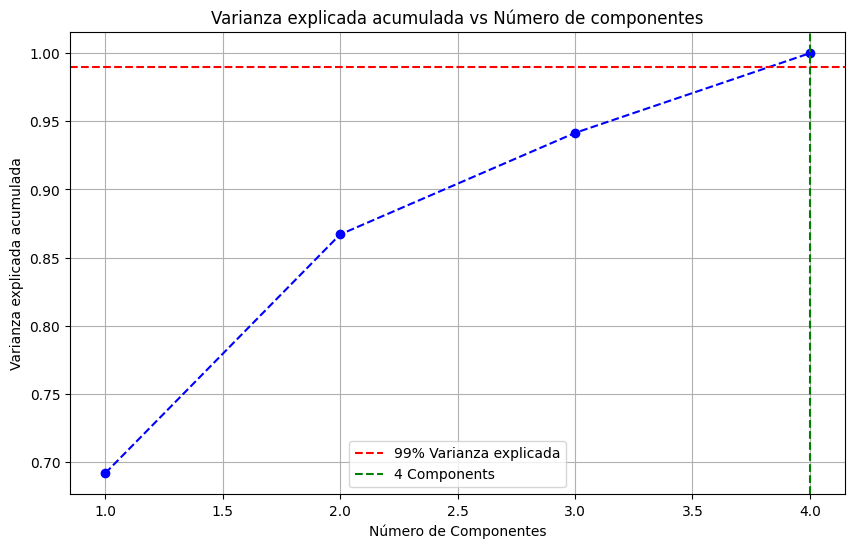

In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_processed)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada vs Número de componentes')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Varianza explicada')  
plt.axvline(x=np.argmax(cumulative_variance >= 0.99) + 1, color='g', linestyle='--', label=f'{np.argmax(cumulative_variance >= 0.99) + 1} Components')
plt.legend(loc='best')
plt.grid()
plt.show()

##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

Inicialmente formulamos el problema de la siguiente manera.

"Como el resultado de un partido puede estar influenciado por resultados anteriores (el rendimiento previo que tuvo el equipo), se decide tratar al dataset como una serie temporal. Por lo tanto, se divide en conjunto de entrenamiento y prueba según una fecha determinada."

Luego al observar los resultados no muy favorables, hicimos el train test split. 

In [103]:
def print_classification_results(y_test, y_pred, model_name, y_proba=None):
    target_names = result_encoder.classes_
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
    
    if y_proba is not None:
        print("Log Loss:", log_loss(y_test, y_proba))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=target_names,
                              zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True,
                xticklabels=target_names,
                yticklabels=target_names)
    plt.tight_layout()
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

In [104]:

from sklearn.impute import SimpleImputer

# Modelo baseline: regresión logística multiclase
# Train / test split already done
X_train = results_filtered[features_numericas + features_categoricas_one_hot + features_categoricas_target]
y_train = results_filtered["result_enc"]

X_test = test_df[features_numericas + features_categoricas_one_hot + features_categoricas_target]
y_test = test_df["result_enc"]

# Column transformers
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# actualmente la lista de features categoricas de poca cardinalidad está vacía, la dejamos por si esto cambia en el futuro
cat_o_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# actualmente la lista de features categoricas para target encoding está vacía, la dejamos por si esto cambia en el futuro
cat_t_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("target", TargetEncoder(handle_unknown="value", handle_missing="value"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, features_numericas),
    ("cat_o", cat_o_transformer, features_categoricas_one_hot),
    ("cat_t", cat_t_transformer, features_categoricas_target)
])


Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación


Resultados para Regresión Logística:

Accuracy: 0.4803921568627451
F1-score (macro): 0.4445233356869618
Log Loss: 1.0275337129642796

Classification Report:
               precision    recall  f1-score   support

        draw       0.27      0.27      0.27      2179
        lose       0.41      0.53      0.46      2657
         win       0.65      0.55      0.59      4752

    accuracy                           0.48      9588
   macro avg       0.45      0.45      0.44      9588
weighted avg       0.50      0.48      0.49      9588



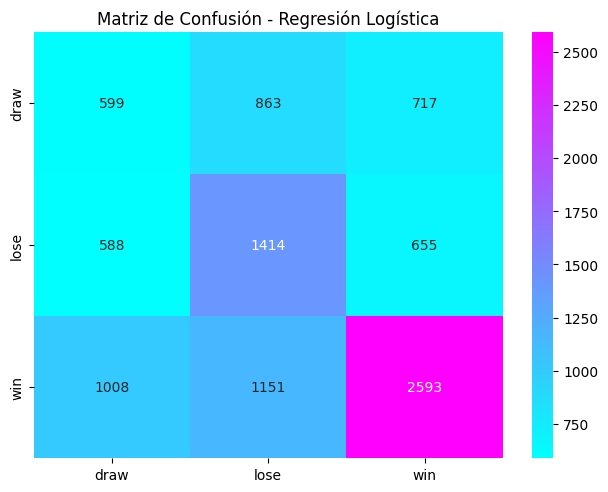

In [105]:
# Regresión logística con balanceo de clases
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

# pipeline
pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', logreg)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "Regresión Logística", y_proba)


Resultados para kNN:

Accuracy: 0.43929912390488113
F1-score (macro): 0.4250373890607672
Log Loss: 1.153868875407459

Classification Report:
               precision    recall  f1-score   support

        draw       0.26      0.41      0.32      2179
        lose       0.41      0.44      0.42      2657
         win       0.65      0.46      0.54      4752

    accuracy                           0.44      9588
   macro avg       0.44      0.43      0.43      9588
weighted avg       0.50      0.44      0.45      9588



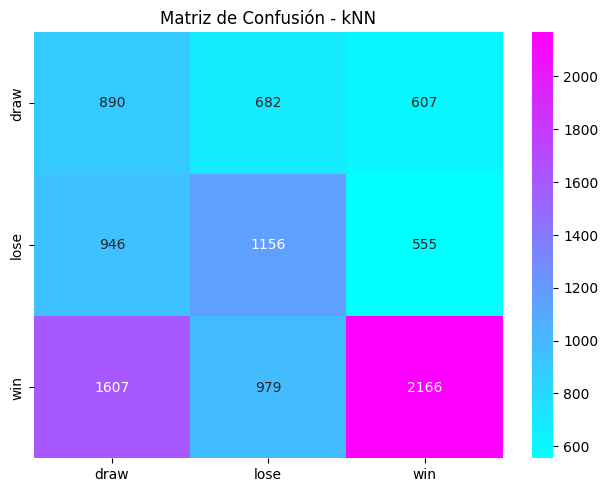

In [106]:
from imblearn.pipeline import Pipeline as ImbPipeline

# KNN
knn = KNeighborsClassifier(n_neighbors=21, metric="minkowski", p=2)

# balance de clases con undersampling
sampler = RandomUnderSampler(random_state=42)

pipeline_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),       
    ('sampler', sampler), # balancea
    ('model', knn)
])

# Train
pipeline_rus.fit(X_train, y_train)

# Predict
y_pred = pipeline_rus.predict(X_test)
y_proba = pipeline_rus.predict_proba(X_test)

print_classification_results(y_test, y_pred, "kNN", y_proba)


Resultados para SVC:

Accuracy: 0.47215269086357947
F1-score (macro): 0.446648888924664
Log Loss: 0.9835511578100596

Classification Report:
               precision    recall  f1-score   support

        draw       0.26      0.34      0.29      2179
        lose       0.44      0.49      0.46      2657
         win       0.66      0.52      0.59      4752

    accuracy                           0.47      9588
   macro avg       0.45      0.45      0.45      9588
weighted avg       0.51      0.47      0.48      9588



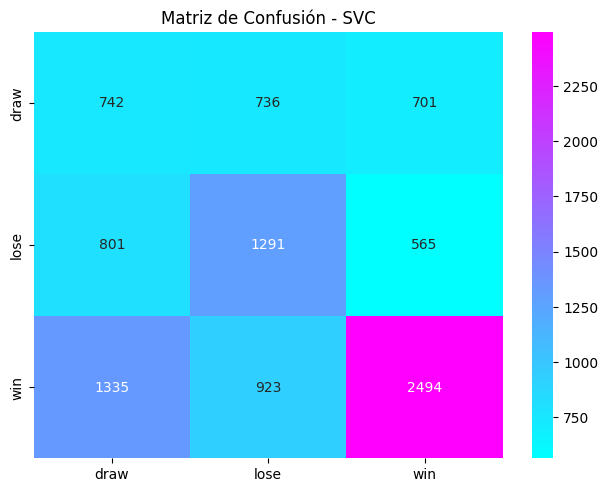

In [107]:
svc = SVC(C=5, kernel="rbf", decision_function_shape='ovo', probability=True, class_weight='balanced', random_state=42)

# pipeline
pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', svc)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "SVC", y_proba)


Resultados para Árbol de Decisión:

Accuracy: 0.44722569879015434
F1-score (macro): 0.4304652506879036
Log Loss: 1.5943044905357895

Classification Report:
               precision    recall  f1-score   support

        draw       0.25      0.40      0.31      2179
        lose       0.43      0.43      0.43      2657
         win       0.65      0.48      0.55      4752

    accuracy                           0.45      9588
   macro avg       0.44      0.44      0.43      9588
weighted avg       0.50      0.45      0.46      9588



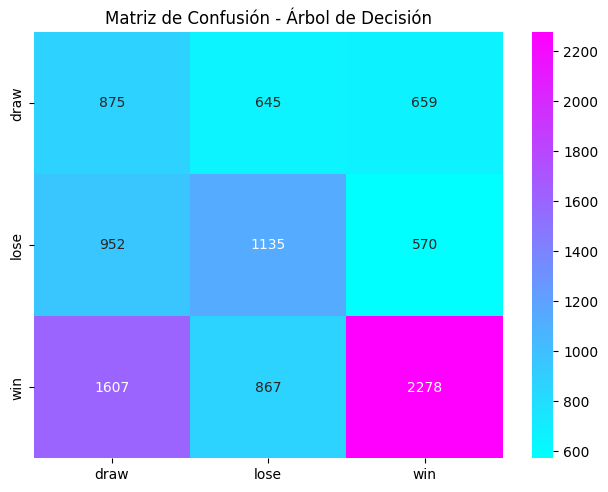

In [108]:
# Arbol de decisión
dtc = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=10, min_samples_split=8, min_samples_leaf=5,
                                        class_weight='balanced',
                                        random_state=42)

# pipeline
pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', dtc)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "Árbol de Decisión", y_proba)


Resultados para Random Forest:

Accuracy: 0.47194409678765126
F1-score (macro): 0.4403412287887308
Log Loss: 1.018478543330245

Classification Report:
               precision    recall  f1-score   support

        draw       0.26      0.32      0.29      2179
        lose       0.42      0.47      0.44      2657
         win       0.64      0.55      0.59      4752

    accuracy                           0.47      9588
   macro avg       0.44      0.44      0.44      9588
weighted avg       0.49      0.47      0.48      9588



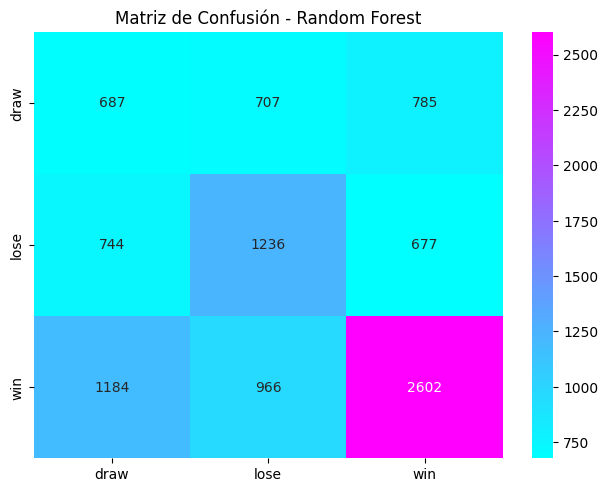

In [109]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)

pipe_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rfc)
])

# Train
pipe_balanced.fit(X_train, y_train)

# Predict
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)

print_classification_results(y_test, y_pred, "Random Forest", y_proba)


Resultados para GradientBoostingClassifier:

Accuracy: 0.43418856904463915
F1-score (macro): 0.4204629219769059
Log Loss: 1.0990892783416508

Classification Report:
               precision    recall  f1-score   support

        draw       0.25      0.40      0.31      2179
        lose       0.41      0.43      0.42      2657
         win       0.64      0.45      0.53      4752

    accuracy                           0.43      9588
   macro avg       0.44      0.43      0.42      9588
weighted avg       0.49      0.43      0.45      9588



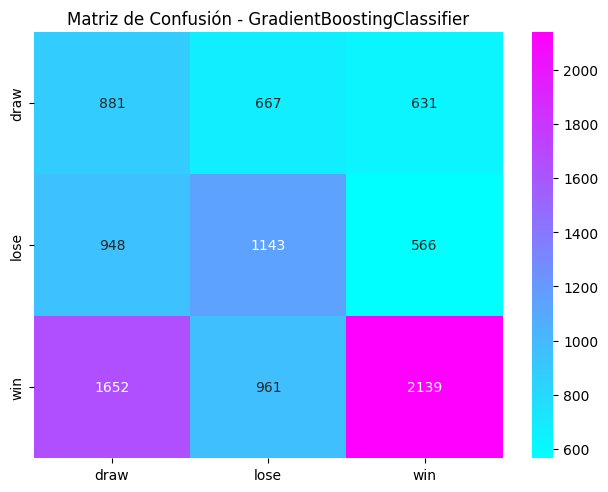

In [110]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(
    n_estimators=300,     # más árboles = mejor performance, hasta cierto punto
    learning_rate=0.05,   # tasa de aprendizaje baja = más estable
    max_depth=10,          # profundidad de cada árbol
    random_state=42
)

# balance de clases con undersampling
sampler = RandomUnderSampler(random_state=42)

pipeline_rus = ImbPipeline(steps=[
    ('preprocessor', preprocessor),       
    ('sampler', sampler), # balancea
    ('model', gb_clf)
])

# Train
pipeline_rus.fit(X_train, y_train)

# Predict
y_pred = pipeline_rus.predict(X_test)
y_proba = pipeline_rus.predict_proba(X_test)

print_classification_results(y_test, y_pred, "GradientBoostingClassifier", y_proba)

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global.

In [111]:
# Comparacion de resultados

---
Para discutir

- ¿Qué otras variables podrían ser útiles para mejorar el modelo? Una ordinal por ejemplo por ranking fifa para los equipos?

- Faltaria agregar ensamble 

- Y si convertimos el problema a uno de clasificación binaria (win vs no win)? Podria simplificar el problema y mejorar los resultados?